<a href="https://colab.research.google.com/github/mitra369/210112-CN_CIFAR10/blob/main/210112_CN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!git clone https://github.com/mitra369/210112-CN_CIFAR10.git


fatal: destination path '210112-CN_CIFAR10' already exists and is not an empty directory.


In [19]:
import os
os.listdir("210112-CN_CIFAR10/dataset/phone image")


['cat1.png',
 'bird1.png',
 'cat3.png',
 'desktop.ini',
 'cat2.png',
 'car2.png',
 'car1.png',
 'dog2.png',
 'bird2.png',
 'car3.png',
 'bird3.png',
 'dog3.png',
 'dog1.png']

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [22]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


In [23]:
trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform)

testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)


In [24]:
classes = ['bird', 'car', 'cat', 'dog']
class_map = [2, 1, 3, 5]   # CIFAR-10 labels


In [25]:
def filter_dataset(dataset):
    idx = [i for i, (_, label) in enumerate(dataset) if label in class_map]
    dataset.data = dataset.data[idx]
    dataset.targets = [class_map.index(dataset.targets[i]) for i in idx]
    return dataset


In [26]:
trainset = filter_dataset(trainset)
testset = filter_dataset(testset)


In [27]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [28]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [29]:
model = CNN().to(device)


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [31]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []

epochs = 10

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_acc.append(correct / total)

    # Validation
    model.eval()
    correct, total, running_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(running_loss / len(testloader))
    val_acc.append(correct / total)

    print(f"Epoch {epoch+1} | "
          f"Train Acc {train_acc[-1]*100:.2f}% | "
          f"Val Acc {val_acc[-1]*100:.2f}%")


Epoch 1 | Train Acc 62.53% | Val Acc 66.50%
Epoch 2 | Train Acc 71.59% | Val Acc 73.67%
Epoch 3 | Train Acc 75.97% | Val Acc 75.60%
Epoch 4 | Train Acc 78.70% | Val Acc 76.17%
Epoch 5 | Train Acc 81.90% | Val Acc 77.25%
Epoch 6 | Train Acc 84.23% | Val Acc 77.85%
Epoch 7 | Train Acc 85.98% | Val Acc 77.45%
Epoch 8 | Train Acc 89.62% | Val Acc 77.60%
Epoch 9 | Train Acc 91.52% | Val Acc 77.58%
Epoch 10 | Train Acc 93.77% | Val Acc 77.10%


In [32]:
torch.save(model.state_dict(), "210112-CN_CIFAR10/model/210112.pth")


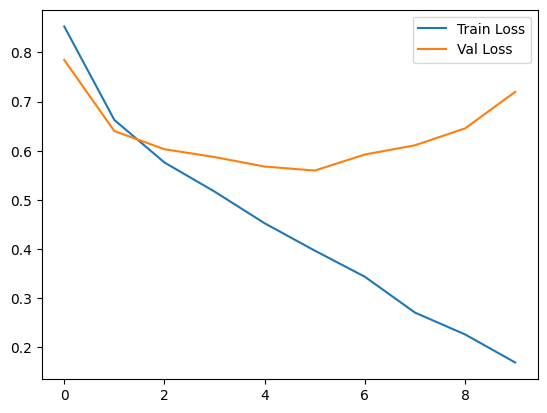

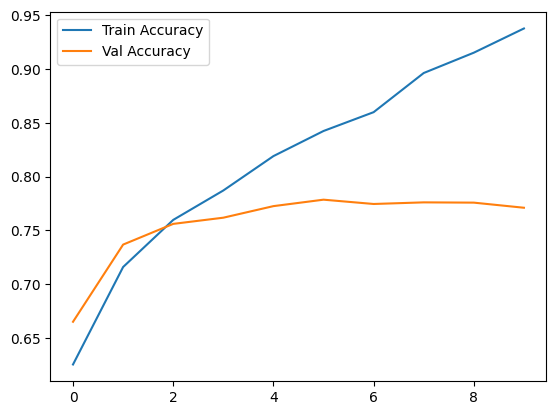

In [33]:
plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.legend()
plt.show()


In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [35]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())


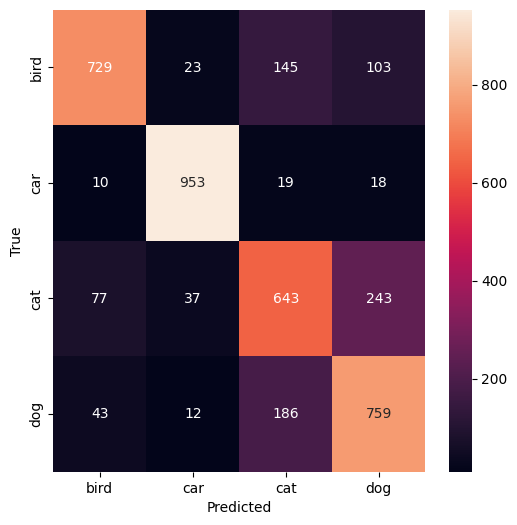

In [36]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [37]:
wrong = [(i, y_true[i], y_pred[i])
         for i in range(len(y_true)) if y_true[i] != y_pred[i]]


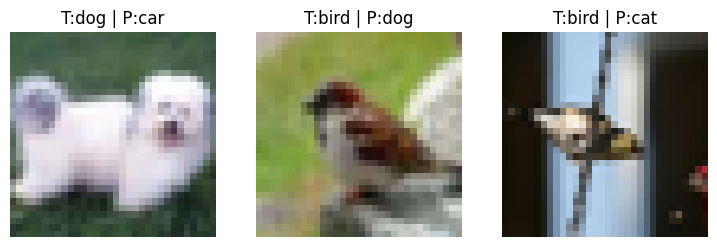

In [38]:
samples = random.sample(wrong, 3)

plt.figure(figsize=(9,3))

for i, (idx, true, pred) in enumerate(samples):
    img = testset[idx][0].permute(1,2,0).numpy()
    img = (img + 1) / 2

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(f"T:{classes[true]} | P:{classes[pred]}")
    plt.axis("off")

plt.show()


In [39]:
phone_dir = "210112-CN_CIFAR10/dataset/phone image"
phone_imgs = os.listdir(phone_dir)


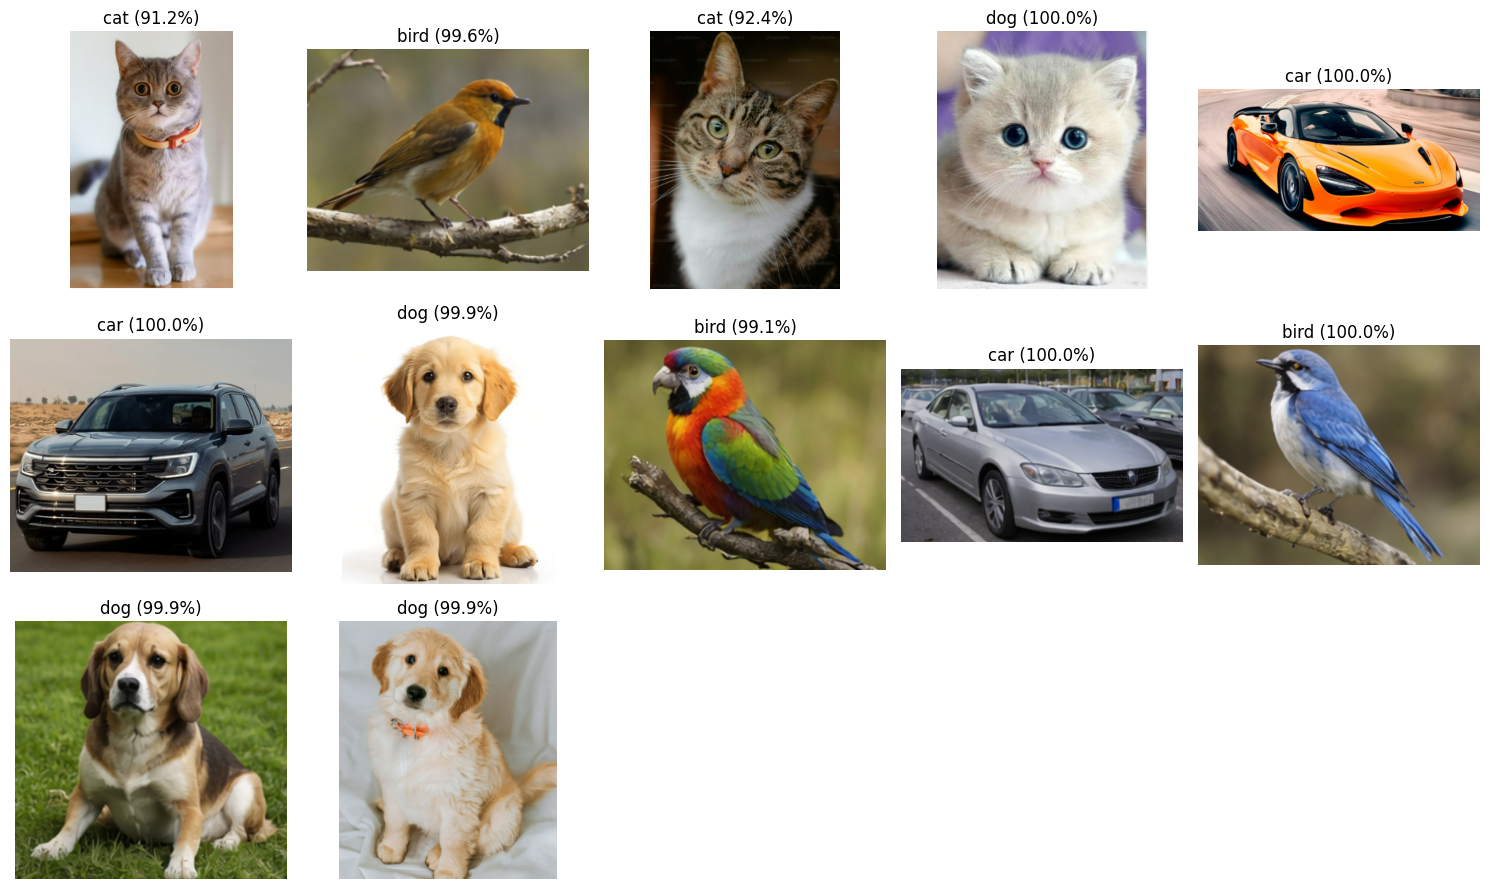

In [42]:
import math

phone_dir = "210112-CN_CIFAR10/dataset/phone image"

phone_imgs = [f for f in os.listdir(phone_dir)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

n = len(phone_imgs)
cols = 5
rows = math.ceil(n / cols)

plt.figure(figsize=(15, 3 * rows))

for i, img_name in enumerate(phone_imgs):
    img_path = os.path.join(phone_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        prob = torch.softmax(output, dim=1)
        conf, pred = torch.max(prob, 1)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{classes[pred.item()]} ({conf.item()*100:.1f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()
